<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/NLP_Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cd /content && git clone --branch=stable https://github.com/bigartm/bigartm.git
!cd /content/bigartm && mkdir build
!cd /content/bigartm/build && cmake -DPYTHON=python3 ..
!cd /content/bigartm/build && make
!cd /content/bigartm/build && sudo make install
!export ARTM_SHARED_LIBRARY=/usr/local/lib/libartm.so
!cd /content/bigartm/python && python setup.py install

In [ ]:
%env ARTM_SHARED_LIBRARY=/usr/local/lib/libartm.so

env: ARTM_SHARED_LIBRARY=/usr/local/lib/libartm.so


In [ ]:
!pip install pandas==1.5.3 > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
!pip install pyLDAvis > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.


In [ ]:
import os
import numpy as np
import pandas as pd
import math
import re
import string
import itertools
import matplotlib.pyplot as plt
import nltk
from pprint import pprint

from collections import Counter
import gensim
from gensim import corpora
from gensim.models import LsiModel, HdpModel, LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

import pyLDAvis
import pyLDAvis.gensim

from wordcloud import WordCloud

import gensim.parsing.preprocessing as gsp
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer

import artm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Loading data and preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/MyDrive/ds_data/topic_modeling/recipes/"
BATCHES_PATH = FILE_PATH + 'artm_batches/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(FILE_PATH + "recipes.csv",)

In [ ]:
df.shape

(38615, 10)

In [ ]:
df.head()

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
0,Пошаговые рецепты/Заготовки/Грузинская кухня,Капуста по‑грузински,13411:Вода\n13410:Сахар\n13421:Соль\n14585:Укс...,30 минут + 5 суток,"0. Смешать воду, сахар и соль, довести до кипе...",zagotovki,91 ккал,"2,7 грамм","0,2 грамм","18,6 грамм"
1,Пошаговые рецепты/Заготовки/Веганская еда,Арбузный мед,14287:Арбуз,5 часов,"0. Арбуз помыть, обсушить и разрезать на четыр...",zagotovki,350 ккал,"8,4 грамм","1,4 грамм","81,2 грамм"
2,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Маринованные опята,14584:Опята\n13422:Уксус\n13421:Соль\n13460:Ла...,40 минут + 1 сутки,0. Промытые опята бросить в кипящую воду и вар...,zagotovki,36 ккал,"2,4 грамм","1,4 грамм","4,6 грамм"
3,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Соленые огурцы по бабушкиному рецепту,15137:Огурцы\n13421:Соль\n14786:Листья черной ...,30 минут + 20 суток,0. Огурцы лучше брать небольшие и плотные. Дли...,zagotovki,142 ккал,"7,4 грамм",1 грамм,"24,9 грамм"
4,Пошаговые рецепты/Заготовки/Варенье,Клубничное варенье с черным перцем,13494:Клубника\n13410:Сахар\n13427:Лимон\n1373...,1 час,0. Вымыть клубнику под проточной водой. Лучше ...,zagotovki,4460 ккал,12 грамм,"4,7 грамм","1083,9 грамм"


In [ ]:
df.iloc[0,4]

'0. Смешать воду, сахар и соль, довести до кипения, затем снять с огня и влить уксус.\n1. Капусту очистить от верхних листьев, нарезать крупными кусками, избавившись от кочерыжки. Морковь и свеклу нарезать тонкой соломкой. У перца удалить семена и измельчить, чеснок также измельчить.\n2. Смешать капусту с остальными овощами и черным перцем, равномерно уложить их в банку, залить маринадом и закрыть крышкой. Оставить на сутки при комнатной температуре, затем убрать в холодильник. Через 3-5 дней капусту можно будет есть.'

#### Auxiliary functions

In [ ]:
def get_corpus_statistics(col, top_num=20, verbose=1):
  # Calculating the total number of words in the corpus and frequency of use for every word
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    try:
      corpus += text
    except:
      print(text)
    corpus += ' '
  #words = remove_punct(corpus).lower().split()
  word_counts = Counter(corpus.split())

  result = {}
  if verbose!=0:
    print('Size of vocabulary: ',len(list(word_counts)))
    print(f'Most {top_num} common words are:')
  for item in word_counts.most_common(top_num):
    result[item[0]] = int(item[1])
  return result

In [ ]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """


    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    ru_stop = set(stopwords.words('russian'))
    # Create p_stemmer of class PorterStemmer
    stemmer = Mystem()

    extended_punct = {'‑', '«', '»'}
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean document string
        raw = i.lower()
        #removing punctuations
        raw = "".join([char if char not in string.punctuation and char not in extended_punct else ' ' for char in raw])
        #removing numbers
        raw=''.join(raw)
        number_pattern = re.compile('\d+')
        raw = number_pattern.sub(r' ', raw)

        tokens = stemmer.lemmatize(raw)

        stopped_tokens = [i for i in tokens if not i in ru_stop and not re.fullmatch('[ \t]+', i) and i != "\n"]

        texts.append(stopped_tokens)
    return texts

In [ ]:
def prepare_corpus(doc_clean):
    """
    Create term dictionary of the corpus and converting list of documents (corpus) into document-term matrix
    Input  : clean document
    Output : dictionary and document-term matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

I chose three columns of the given dataset in order to perform the task of topic modeling - title, ingredients, and tags. I also tried other combinations, like adding a 'steps' column, but in my opinion, it contains a lot of common words not unique for any of the topics (words like 'cook', 'boil', 'chop' in Russian), so this only contaminates data. So I combine the three mentioned columns into one for further processing:

In [ ]:
df['full_text'] = df.title + ' ' + df.ingredients + ' ' + df.tags
df.full_text.iloc[:5]

0    Капуста по‑грузински 13411:Вода\n13410:Сахар\n...
1    Арбузный мед 14287:Арбуз Пошаговые рецепты/Заг...
2    Маринованные опята 14584:Опята\n13422:Уксус\n1...
3    Соленые огурцы по бабушкиному рецепту 15137:Ог...
4    Клубничное варенье с черным перцем 13494:Клубн...
Name: full_text, dtype: object

Removing empty rows:

In [ ]:
df.full_text.isna().sum()

5

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.shape

(38608, 11)

Packing obtained messages into the list:

In [ ]:
texts = df.full_text.values.tolist()
texts[:5]

['Капуста по‑грузински 13411:Вода\n13410:Сахар\n13421:Соль\n14585:Уксус 9%-ный\n13436:Белокочанная капуста\n13438:Свекла\n13449:Морковь\n13506:Перец чили\n13430:Чеснок\n13737:Черный перец горошком Пошаговые рецепты/Заготовки/Грузинская кухня',
 'Арбузный мед 14287:Арбуз Пошаговые рецепты/Заготовки/Веганская еда',
 'Маринованные опята 14584:Опята\n13422:Уксус\n13421:Соль\n13460:Лавровый лист\n13410:Сахар\n13737:Черный перец горошком\n13430:Чеснок\n13621:Гвоздика\n26851:Душистый перец горошком Пошаговые рецепты/Заготовки/Русская кухня/Соленья и консервация',
 'Соленые огурцы по бабушкиному рецепту 15137:Огурцы\n13421:Соль\n14786:Листья черной смородины\n14742:Листья хрена\n13437:Хрен\n13506:Перец чили\n19146:Стебли укропа\n14585:Уксус 9%-ный Пошаговые рецепты/Заготовки/Русская кухня/Соленья и консервация',
 'Клубничное варенье с черным перцем 13494:Клубника\n13410:Сахар\n13427:Лимон\n13737:Черный перец горошком Пошаговые рецепты/Заготовки/Варенье']

Performing preprocessing using previously defined function:

In [ ]:
clean_texts = preprocess_data(texts)

As the output of the preprocessing function we got lists of lemmatized tokens for every given recipe, packed in the list:

In [ ]:
clean_texts[:2]

[['капуста',
  'грузински',
  'вода',
  'сахар',
  'соль',
  'уксус',
  'ный',
  'белокочанный',
  'капуста',
  'свекла',
  'морковь',
  'перец',
  'чили',
  'чеснок',
  'черный',
  'перец',
  'горошек',
  'пошаговый',
  'рецепт',
  'заготовка',
  'грузинский',
  'кухня'],
 ['арбузный',
  'мед',
  'арбуз',
  'пошаговый',
  'рецепт',
  'заготовка',
  'веганский',
  'еда']]

Lets visualize our data using WordCloud. On the following plot we can see the most frequent words and bigrams in the dataset:

In [ ]:
whole_text = list(itertools.chain.from_iterable(clean_texts))

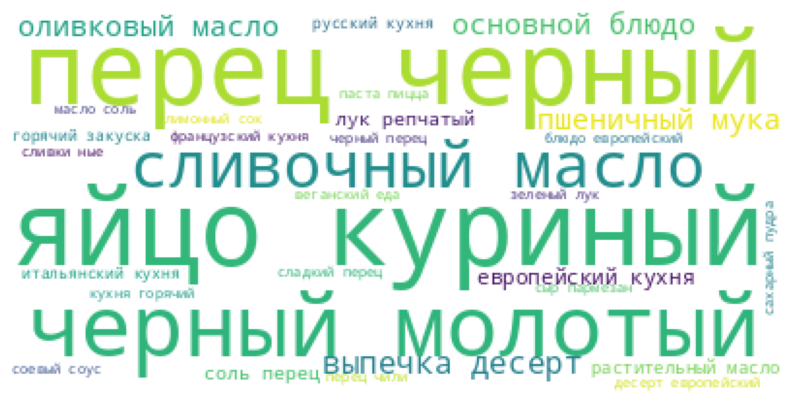

In [ ]:
wordcloud = WordCloud(background_color ='white', min_font_size = 7).generate(" ".join(whole_text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

I decided to remove several most frequent words from texts before further analysis as they worsen topic modeling results:

In [ ]:
common_words = get_corpus_statistics(clean_texts, 4)
common_words

Size of vocabulary:  6804
Most 4 common words are:


{'кухня': 29484, 'масло': 27771, 'соль': 21521, 'перец': 21271}

In [ ]:
more_common_words = ['блюда', 'молотый', 'черный', 'ный', 'ные']
common_words = list(common_words.keys())
common_words.extend(more_common_words)

In [ ]:
def remove_common(clean_texts):
  texts = []
  for text in clean_texts:
    text = [i for i in text if not i in common_words]
    texts.append(text)
  return texts

In [ ]:
clean_texts = remove_common(clean_texts)

Add bigrams and trigrams as a separate tokens to our cleaned data. Minimum count 10 means that we take only bigrams that appear 10 times or more:

In [ ]:
#Create Biagram & Trigram Models
from gensim.models import Phrases

bigram = Phrases(clean_texts, min_count=10)
trigram = Phrases(bigram[clean_texts])

for idx in range(len(clean_texts)):
    for token in bigram[clean_texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            clean_texts[idx].append(token)
    for token in trigram[clean_texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            clean_texts[idx].append(token)

Create a dictionary representation of the documents and corpus (term-document matrix) required for topic modeling:

In [ ]:
dictionary, corpus = prepare_corpus(clean_texts)
dictionary.filter_extremes(no_below=10, no_above=0.2)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3350
Number of documents: 38608


In [ ]:
print(corpus[:1])

[[(0, 1), (1, 15), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 10), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


Human readable format of corpus (term-frequency):

In [ ]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('белокочанный', 1),
  ('белокочанный_капуста', 15),
  ('вода', 1),
  ('горошек', 1),
  ('грузински', 1),
  ('грузинский', 1),
  ('заготовка', 1),
  ('капуста', 2),
  ('морковь', 1),
  ('пошаговый', 1),
  ('пошаговый_рецепт', 10),
  ('рецепт', 1),
  ('свекла', 1),
  ('уксус', 1),
  ('чили', 1),
  ('арбуз', 1),
  ('арбузный', 1)]]

## LSA (Latent Semantic Analysis)

In [ ]:
def create_gensim_lsa_model(dictionary,doc_term_matrix,number_of_topics,words):
    """
    Create LSA model using gensim and print its topics
    Input  : dictionary, doc-term matrix, number of topics and number of words associated with each topic
    Output : return LSA model
    """
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    pprint(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LSA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

To identify optimal number of topics I am calculating coherence for different number of topics using previously defined function:

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary, corpus, clean_texts, stop=15, start=2, step=1)

In [ ]:
for i, model in enumerate(model_list):
  print(f"Number of topics: {model.num_topics} - Coherence: {coherence_values[i]}")

Number of topics: 2 - Coherence: 0.3629348179185895
Number of topics: 3 - Coherence: 0.351585569631692
Number of topics: 4 - Coherence: 0.42441710411981903
Number of topics: 5 - Coherence: 0.42337650028594076
Number of topics: 6 - Coherence: 0.4192715985069588
Number of topics: 7 - Coherence: 0.41747838738916343
Number of topics: 8 - Coherence: 0.3907541874902007
Number of topics: 9 - Coherence: 0.373178655288285
Number of topics: 10 - Coherence: 0.3674732807549995
Number of topics: 11 - Coherence: 0.34035167654126547
Number of topics: 12 - Coherence: 0.34868062331795385
Number of topics: 13 - Coherence: 0.33209328233305513
Number of topics: 14 - Coherence: 0.32376551041883944


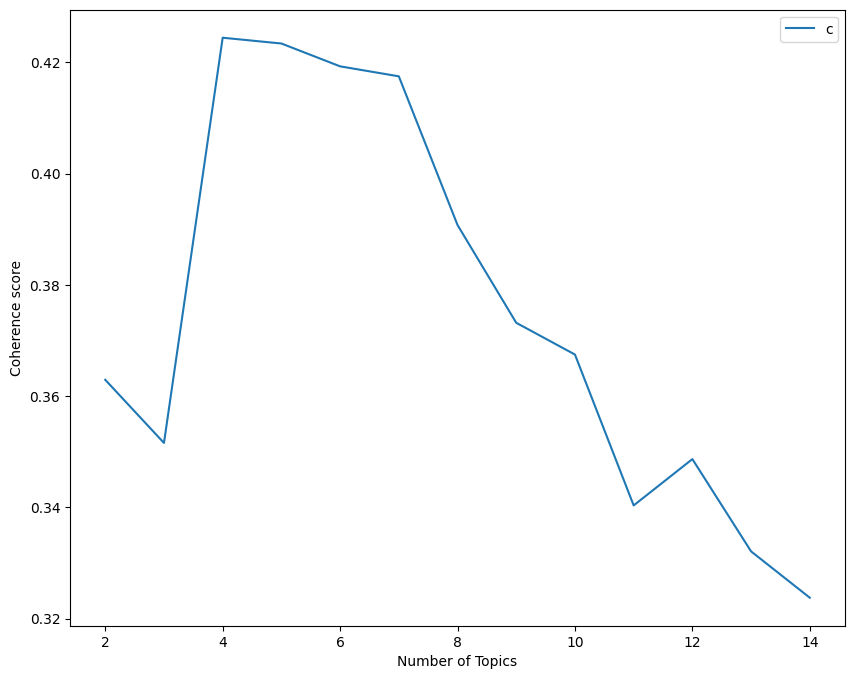

In [ ]:
def plot_graph(model_list, coherence_values):

    x = [model.num_topics for model in model_list]
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

plot_graph(model_list, coherence_values)

Surprisingly I got 4 as the best choice although earlier there were different results of this analysis. So let's build LSA model for 4 topics:

In [ ]:
number_of_topics=4
words=20

lsa_model=create_gensim_lsa_model(dictionary, corpus, number_of_topics, words)

[(0,
  '0.530*"выпечка_десерт" + 0.495*"пшеничный_мука" + 0.193*"куриный" + '
  '0.187*"сахар" + 0.185*"мука" + 0.180*"десерт" + 0.179*"выпечка" + '
  '0.167*"пшеничный" + 0.157*"яйцо" + 0.146*"сливочный" + '
  '0.135*"основной_блюдо" + 0.107*"лук" + 0.106*"сахарный_пудра" + '
  '0.100*"горячий_закуска" + 0.083*"сыр" + 0.083*"молоко" + '
  '0.079*"европейский" + 0.075*"лимонный_сок" + 0.071*"пирог" + 0.068*"блюдо"'),
 (1,
  '0.392*"основной_блюдо" + -0.367*"выпечка_десерт" + 0.316*"горячий_закуска" '
  '+ 0.241*"лук" + 0.197*"блюдо" + 0.196*"основной" + 0.176*"закуска" + '
  '0.165*"чеснок" + 0.146*"салат" + 0.139*"соус" + 0.138*"оливковый" + '
  '0.128*"соевый_соус" + -0.125*"десерт" + -0.124*"выпечка" + 0.110*"сыр" + '
  '-0.108*"пшеничный_мука" + 0.107*"репчатый" + 0.107*"лимонный_сок" + '
  '0.107*"горячий" + 0.104*" \n'
  '"'),
 (2,
  '0.565*"салат" + -0.344*"горячий_закуска" + -0.281*"основной_блюдо" + '
  '-0.260*"пшеничный_мука" + 0.228*"лимонный_сок" + -0.141*"блюдо" + '
  '-0

Subjectively I would say that these topics aren't coherent enough as there are different kinds of meals (like dessert and pizza) mixed up in every topic. Let's try with 7 topics:

In [ ]:
# LSA Model
number_of_topics=7
words=10

model=create_gensim_lsa_model(dictionary, corpus, number_of_topics, words)


[(0,
  '0.522*"выпечка_десерт" + 0.515*"пшеничный_мука" + 0.199*"куриный" + '
  '0.192*"мука" + 0.186*"сахар" + 0.177*"десерт" + 0.176*"выпечка" + '
  '0.174*"пшеничный" + 0.162*"яйцо" + 0.146*"сливочный"'),
 (1,
  '0.390*"основной_блюдо" + -0.339*"выпечка_десерт" + 0.320*"горячий_закуска" '
  '+ 0.245*"лук" + 0.196*"блюдо" + 0.195*"основной" + 0.177*"закуска" + '
  '0.171*"чеснок" + 0.144*"оливковый" + 0.142*"салат"'),
 (2,
  '0.430*"салат" + 0.370*"лимонный_сок" + -0.357*"пшеничный_мука" + '
  '-0.275*"основной_блюдо" + -0.233*"горячий_закуска" + 0.227*"выпечка_десерт" '
  '+ 0.166*"лимонный" + 0.165*"сок" + -0.138*"блюдо" + -0.137*"основной"'),
 (3,
  '-0.584*"горячий_закуска" + 0.325*"пшеничный_мука" + -0.307*"выпечка_десерт" '
  '+ -0.297*"закуска" + 0.237*"паста_пицца" + -0.197*"горячий" + 0.155*"паста" '
  '+ 0.148*"салат" + 0.136*"сыр_пармезан" + 0.125*"суп"'),
 (4,
  '0.457*"основной_блюдо" + -0.386*"горячий_закуска" + -0.319*"паста_пицца" + '
  '-0.298*"закуска" + 0.230*"блюд

These topics seems more coherent then in previous experiment, though they aren't perfect.

Calculating UCI and UMass coherence scores and saving them for further comparison with other models:

In [ ]:
# Compute Coherence Score UCI
coherence_lsa = CoherenceModel(model=model,
                              texts=clean_texts,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='c_uci')
lsa_uci = coherence_lsa.get_coherence()
print('\nCoherence Score (UCI): ', lsa_uci)

# Compute Coherence Score using UMass
coherence_lsa = CoherenceModel(model=model,
                              texts=clean_texts,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='u_mass')
lsa_umass = coherence_lsa.get_coherence()
print('\nCoherence Score (UMass): ', lsa_umass)


Coherence Score (UCI):  -1.0332951625141582

Coherence Score (UMass):  -2.5880573926913866


In [ ]:
coherence_dict = {'LSA': [lsa_uci, lsa_umass]}

In [ ]:
lsitopics = model.show_topics(formatted=False)

In [ ]:
lsitopics

[(0,
  [('выпечка_десерт', 0.5217514152970972),
   ('пшеничный_мука', 0.5151538540228399),
   ('куриный', 0.1990669840787092),
   ('мука', 0.1921836876152108),
   ('сахар', 0.18573869016461986),
   ('десерт', 0.17729270439401973),
   ('выпечка', 0.1757286902444137),
   ('пшеничный', 0.17351524852446143),
   ('яйцо', 0.16209136409367475),
   ('сливочный', 0.14604118624918674)]),
 (1,
  [('основной_блюдо', 0.39002283049193626),
   ('выпечка_десерт', -0.33942183174691926),
   ('горячий_закуска', 0.31952580873260555),
   ('лук', 0.2446065018988581),
   ('блюдо', 0.19602470526067467),
   ('основной', 0.1953448321901977),
   ('закуска', 0.17745307599769772),
   ('чеснок', 0.1709184120508766),
   ('оливковый', 0.14406754920203677),
   ('салат', 0.1422678960107097)]),
 (2,
  [('салат', 0.4300631386821593),
   ('лимонный_сок', 0.3695422887210258),
   ('пшеничный_мука', -0.35702060873884356),
   ('основной_блюдо', -0.2747041016069017),
   ('горячий_закуска', -0.2328725514791568),
   ('выпечка_де

## HDP (Hierarchical Dirichlet process)

Unlike LSA and LDA, the HDP topic model infers the number of topics from the data so we don't need to specify the number of topics when creating the model.

Instantiating the HDP model:

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

And show top-10 topics it provides:

In [ ]:
hdpmodel.show_topics(num_topics=10, num_words=20)

[(0,
  '0.031*основной_блюдо + 0.019*лук + 0.019*горячий_закуска + 0.016*блюдо + 0.015*основной + 0.013*чеснок + 0.012*куриный + 0.012*пшеничный_мука + 0.011*соевый_соус + 0.011*соус + 0.010*оливковый + 0.010* \n + 0.010*закуска + 0.009*репчатый + 0.008*салат + 0.008*сыр + 0.008*сухой_вино + 0.007*красный + 0.007*помидор + 0.007*зеленый'),
 (1,
  '0.019*салат + 0.016*основной_блюдо + 0.015*лук + 0.013*горячий_закуска + 0.012*лимонный_сок + 0.011*оливковый + 0.010*чеснок + 0.010*куриный + 0.010*закуска + 0.009*соус + 0.009*пшеничный_мука + 0.009* \n + 0.008*красный + 0.008*блюдо + 0.008*основной + 0.008*помидор + 0.008*веганский_еда + 0.007*зеленый + 0.007*соевый_соус + 0.007*сыр'),
 (2,
  '0.074*выпечка_десерт + 0.057*пшеничный_мука + 0.025*десерт + 0.025*выпечка + 0.025*сахар + 0.022*мука + 0.019*куриный + 0.019*пшеничный + 0.019*яйцо + 0.016*сливочный + 0.016*сахарный_пудра + 0.011*молоко + 0.010*пирог + 0.009*яичный_желток + 0.008*грецкий_орех + 0.008*европейский + 0.008*какао_порош

Calculating coherence of the obtained topics:

In [ ]:
# Compute Coherence Score UCI
coherence_hdp = CoherenceModel(model=hdpmodel,
                              texts=clean_texts,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='c_uci')
hdp_uci = coherence_hdp.get_coherence()
print('\nCoherence Score (UCI): ', hdp_uci)

# Compute Coherence Score using UMass
coherence_hdp = CoherenceModel(model=hdpmodel,
                              texts=clean_texts,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='u_mass')
hdp_umass = coherence_hdp.get_coherence()
print('\nCoherence Score (UMass): ', hdp_umass)


Coherence Score (UCI):  -2.7648430671709114

Coherence Score (UMass):  -5.731748093384916


In [ ]:
coherence_dict['HDP']=[hdp_uci, hdp_umass]

In [ ]:
hdptopics = hdpmodel.show_topics(formatted=False)

## LDA (Latent Dirichlet Allocation)

As the fist step I need to find out the optimal number of topics. I use the function plotting coherence for

In [ ]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Plots coherence scores for various num_topics values for LDA
    Inputs:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    Outputs:
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())

    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

    return lm_list, c_v

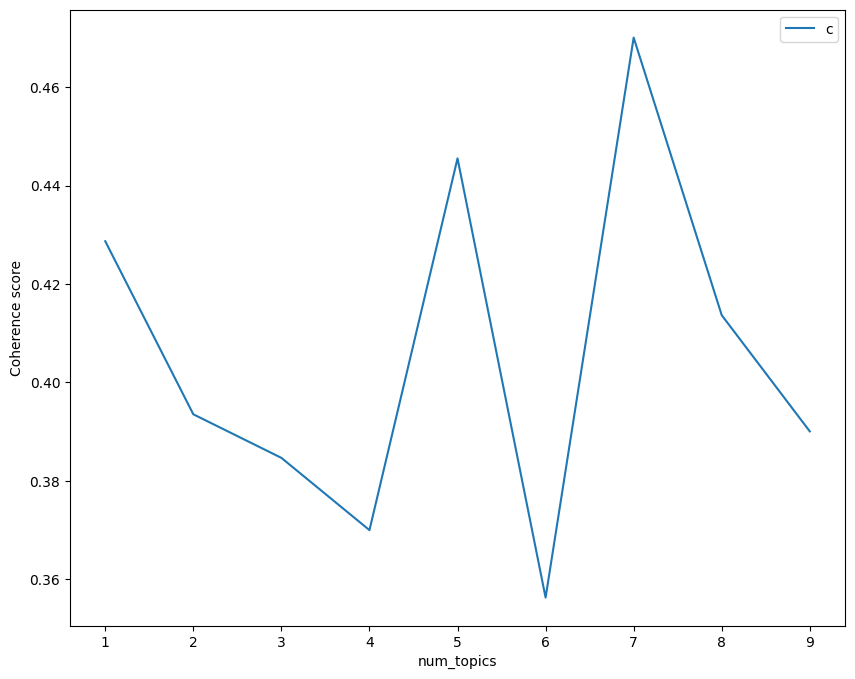

CPU times: user 2min 13s, sys: 1.49 s, total: 2min 14s
Wall time: 2min 16s


In [ ]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=clean_texts, limit=10)

We can see on the plot that the maximum coherence score obtained by LDA model with 7 topics, so let's take this number.

Training the LDA model:

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=7,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

Print keywords for the obtained topics:

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.104*"пшеничный_мука" + 0.071*"соевый_соус" + 0.041*"мука" + '
  '0.036*"пшеничный" + 0.035*"куриный" + 0.035*"яйцо" + 0.030*"молоко" + '
  '0.029*"сахар" + 0.028*"тертый_имбирь" + 0.025*"сливочный"'),
 (1,
  '0.041*"соус" + 0.037*"лук" + 0.029*"чеснок" + 0.022*"бульон" + 0.017*" \n'
  '" + 0.016*"сыр_пармезан" + 0.016*"сыр" + 0.016*"репчатый" + 0.015*"куриный" '
  '+ 0.015*"оливковый"'),
 (2,
  '0.076*"лимонный_сок" + 0.061*"маринад" + 0.058*"напиток" + 0.048*"сок" + '
  '0.038*"лимонный" + 0.025*"суп" + 0.021*"европейский" + 0.021*"сахар" + '
  '0.019*"напиток_авторский" + 0.018*"вода"'),
 (3,
  '0.170*"соус_маринад" + 0.048*"веганский_еда" + 0.044*"коктейль" + '
  '0.036*"сухой_вино" + 0.034*"еда" + 0.028*"вегетарианский_еда" + '
  '0.024*"низкокалорийный_еда" + 0.022*"соус" + 0.020*"сок_лайма" + '
  '0.017*"бальзамический_уксус"'),
 (4,
  '0.118*"закуска" + 0.098*"горячий_закуска" + 0.039*"горячий" + '
  '0.029*"мускатный_орех" + 0.025*"орех" + 0.024*"сэндвич" + 0.022*"сыр

Calculating perplexity and coherence scores:

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_texts, dictionary=dictionary, coherence='c_uci')
lda_uci = coherence_model_lda.get_coherence()
print('\nCoherence Score (UCI): ', lda_uci)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_texts, dictionary=dictionary, coherence="u_mass")
lda_umass = coherence_model_lda.get_coherence()
print('\nCoherence Score (UMass): ', lda_umass)


Perplexity:  -6.496387333423438

Coherence Score (UCI):  -1.6073611997297668

Coherence Score (UMass):  -4.1543679754444875


In [ ]:
coherence_dict['LDA']=[lda_uci, lda_umass]

Visualizing topics using WordCloud:

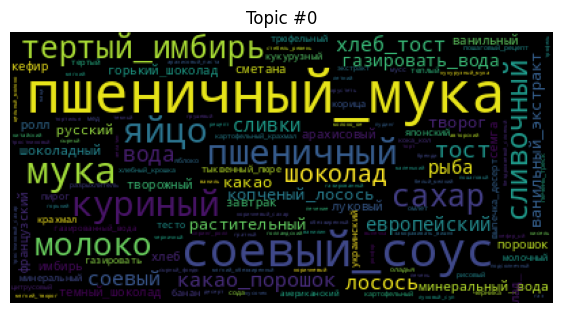

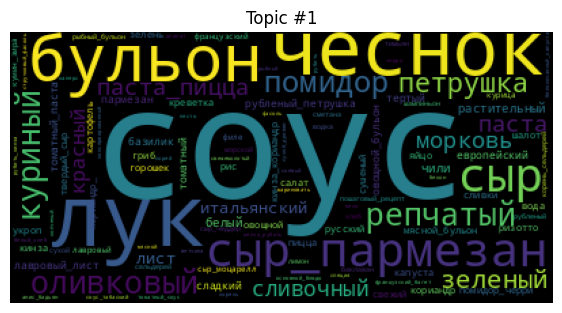

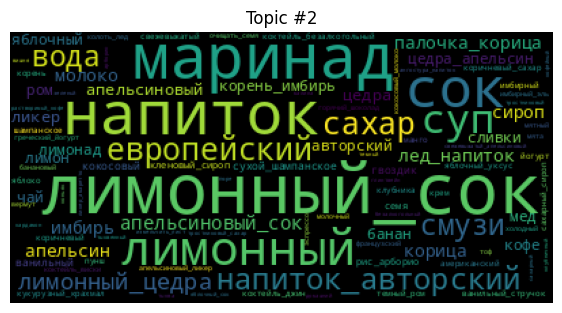

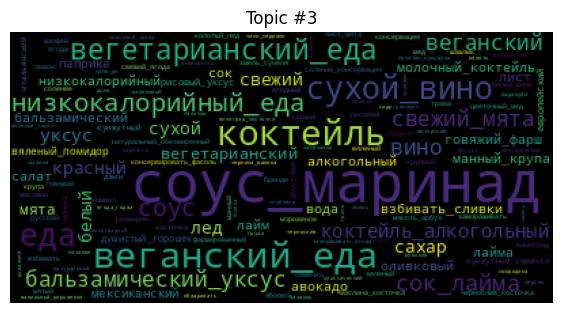

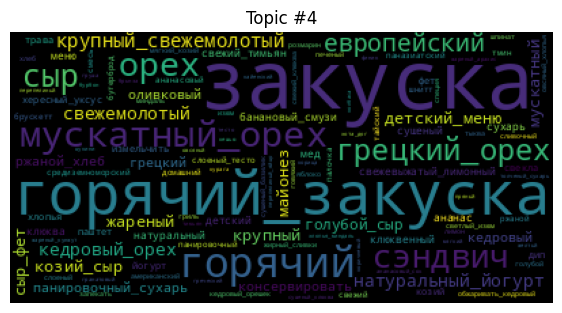

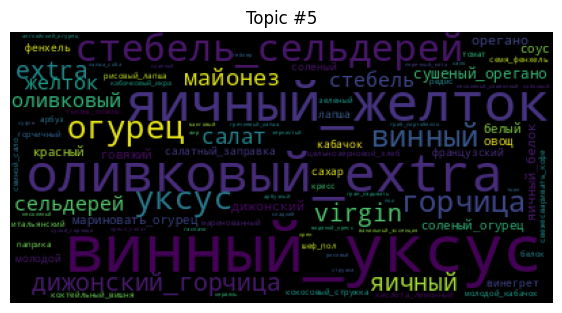

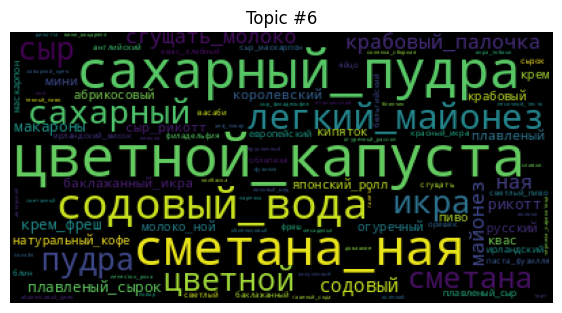

In [ ]:
for t in range(lda_model.num_topics):
    plt.figure(figsize=(7,4))
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

Another tool using to visualize LDA topics is pyLDAvis. PyLDAvis allows us to interpret the topics - we can visually see a topic map, intertopic distances, intersections, and top terms for every topic. Below the visualization for our 7-topic LDA model is present:

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.094431  0.027260       1        1  39.424842
0     -0.213290  0.107044       2        1  20.252981
4     -0.005516 -0.065901       3        1  10.993610
3      0.178063  0.174850       4        1  10.560799
2     -0.229822  0.182260       5        1   8.805834
5      0.305345 -0.055996       6        1   6.297843
6     -0.129210 -0.369516       7        1   3.664091, topic_info=                 Term          Freq         Total Category  logprob  loglift
7231     соус_маринад  20141.000000  20141.000000  Default  30.0000  30.0000
119    пшеничный_мука  23649.000000  23649.000000  Default  29.0000  29.0000
425           закуска  14645.000000  14645.000000  Default  28.0000  28.0000
424   горячий_закуска  12052.000000  12052.000000  Default  27.0000  27.0000
1427      соевый_соус  16177.000000  16177.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
1985        огуречный    310.593810    311.681243   Topic7  -4.8875   3.3031
244          сахарный   1058.239731   1265.448122   Topic7  -3.6616   3.1278
190           сметана    846.052687   3176.399909   Topic7  -3.8854   1.9837
139           майонез    678.295514   3484.743180   Topic7  -4.1064   1.6700
192               сыр    897.674882  10723.175923   Topic7  -3.8262   0.8262

[313 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
132       1  0.813983             \n
132       2  0.013868             \n
132       3  0.017640             \n
132       4  0.062571             \n
132       5  0.085204             \n
...     ...       ...            ...
299       6  0.999765  яичный_желток
258       1  0.219067           яйцо
258       2  0.764691           яйцо
258       7  0.016245           яйцо
3274      7  0.996461  японский_ролл

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 3, 6, 7])

In [ ]:
ldatopics = lda_model.show_topics(formatted=False)

## BigARTM (Additive Regularization of Topic Models)

Next I would like to try BigARTM library which uses a novel technique called Additive Regularization of Topic Models. BigARTM is known to combine well very different objectives, including sparsing, smoothing, topics decorrelation and many others. Such combination of regularizers significantly improves several quality measures.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
clearned_texts = [" ".join(text) for text in clean_texts]
clearned_texts[:3]

Here are explanations of the following steps (in reverse order):

*   To proceed with the ARTM models we need to compose artm.Dictionary
*   Dictionary is created by gathering data from batches
*   Batches are made using a special class BatchVectorizer which converts various text formats into the BigARTM internal format
*   To use BatchVectorizer over our given data I need to provide it with a term-document matrix and vocabulary {id: term}, which I get using sklearn CountVectorizer

So let's prepare data for ARTM modeling:


Obtaining of term-doc matrix:

In [ ]:
coun_vect = CountVectorizer()
count_matrix = coun_vect.fit_transform(clearned_texts)
count_array = count_matrix.toarray()
term_doc_df = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())

In [ ]:
count_array = np.transpose(count_array)

In [ ]:
count_array.shape

In [ ]:
coun_vect.vocabulary_.get('ячмень')

Preparing the vocabulary:

In [ ]:
vocab = {y: x for x, y in coun_vect.vocabulary_.items()}

Instantiating a BatchVectorizer object:

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=count_array, vocabulary=vocab, target_folder='my_collection_batches')

Saving batches on the Google Drive so I can later use them straightaway as the process of their creating is quite time consuming:

In [ ]:
!cp ./my_collection_batches/* /content/drive/MyDrive/ds_data/topic_modeling/recipes/artm_batches/

####Workaround: Loading batches

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='./drive/MyDrive/ds_data/topic_modeling/recipes/artm_batches/',
                                        data_format='batches')

<<< End of workaround >>>

Creating ARTM Dictionary object:

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='./drive/MyDrive/ds_data/topic_modeling/recipes/artm_batches/')

In [ ]:
dictionary.save(dictionary_path='./my_collection_batches/my_dictionary')

Now we have all we need for experiments with ARTM models.

#### Basic PLSA model

First, I will use the simple ARTM model without any regularisations:

In [ ]:
artm_model = artm.ARTM(num_topics=10, dictionary=dictionary)

We can add a perplexity score in the model to be able to monitor it at any time:

In [ ]:
artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))

Training the model over our batched data:

In [ ]:
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

Getting the perplexity score:

In [ ]:
artm_model.score_tracker['perplexity_score'].last_value

184.4718780517578

Trying more passes over the collection and over every document (potentially it could improve metrics):

In [ ]:
artm_model.num_document_passes = 10
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

And this definitely works - perplexity improves:

In [ ]:
artm_model.score_tracker['perplexity_score'].last_value

174.0731658935547

#### Regularized PLSA model

Next, I am going to improve base ARTM model by using different regularizers.

In [ ]:
model_reg = artm.ARTM(num_topics=20, dictionary=dictionary)
model_reg.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))

Let's add the scores of sparsity of theta
 and phi
 matrices and the information about the most probable tokens in each topic (top-tokens):

In [ ]:
model_reg.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model_reg.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model_reg.scores.add(artm.TopTokensScore(name='top_tokens_score'))

let's ask the top-tokens score to show us 12 most probable tokens in each topic:

In [ ]:
model_reg.num_tokens = 12

Fitting the model without regularizers:

In [ ]:
model_reg.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

Printing scores:

In [ ]:
print(model_reg.score_tracker['perplexity_score'].last_value)
print(model_reg.score_tracker['sparsity_phi_score'].last_value)
print(model_reg.score_tracker['sparsity_theta_score'].last_value)

139.9718780517578
0.5695748329162598
0.14862851798534393


 In order to see top tokens for each topic we need to use the ```last_tokens``` field. It is a Python dict, where key is a topic name, and value is a list of top-tokens of this topic.

In [ ]:
saved_top_tokens = model_reg.score_tracker['top_tokens_score'].last_tokens

for topic_name in model_reg.topic_names:
    print(saved_top_tokens[topic_name])

['сок', 'лимонный', 'цедра', 'шпинат', 'лосось', 'лайма', 'оливковый', 'спаржа', 'лист', 'семга']
['орех', 'грецкий', 'тыква', 'мускатный', 'корица', 'кориандр', 'семя', 'имбирь', 'кинза', 'гвоздик']
['мука', 'пшеничный', 'яйцо', 'куриный', 'выпечка', 'сахар', 'десерт', 'сливочный', 'молоко', 'пирог']
['помидор', 'чеснок', 'лук', 'оливковый', 'репчатый', 'красный', 'баклажан', 'томатный', 'цукини', 'еда']
['капуста', 'сыр', 'сырный', 'цветной', 'сметана', 'белокочанный', 'кальмар', 'рулет', 'чеддер', 'соленый']
['закуска', 'горячий', 'красный', 'чеснок', 'вино', 'оливковый', 'сухой', 'белый', 'петрушка', 'свежий']
['огурец', 'майонез', 'горчица', 'лук', 'салат', 'уксус', 'зеленый', 'сыр', 'бальзамический', 'свекла']
['куриный', 'яйцо', 'сыр', 'зелень', 'филе', 'европейский', 'сухарь', 'грудка', 'ветчина', 'панировочный']
['белый', 'сливочный', 'сливки', 'лук', 'хлеб', 'французский', 'ные', 'рецепт', 'пошаговый', 'репчатый']
['блюдо', 'основной', 'говяжий', 'имбирь', 'фарш', 'кунжутный'

Probably the topics are not very good. For the aim of increasing the quality of the topics we can use the regularizers:

In [ ]:
model_reg.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
model_reg.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))
model_reg.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer'))

I am taking values from the manual. Probably better values could be found but its demands of long experimenting process.

In [ ]:
model_reg.regularizers['sparse_phi_regularizer'].tau = -1.0
model_reg.regularizers['sparse_theta_regularizer'].tau = -0.5
model_reg.regularizers['decorrelator_phi_regularizer'].tau = 1e+5

In [ ]:
model_reg.num_document_passes = 10

Fitting the model with regularizers:

In [ ]:
model_reg.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

Let's check scores:

In [ ]:
print(model_reg.score_tracker['perplexity_score'].last_value)
print(model_reg.score_tracker['sparsity_phi_score'].last_value)
print(model_reg.score_tracker['sparsity_theta_score'].last_value)

136.85072326660156
0.9601565003395081
0.7758275270462036


They become better!

Looking on top-10 terms in every of obtained topics:

In [ ]:
saved_top_tokens = model_reg.score_tracker['top_tokens_score'].last_tokens

for topic_name in model_reg.topic_names:
    print(saved_top_tokens[topic_name])

['сок', 'лимонный', 'цедра', 'шпинат', 'лосось', 'лайма', 'семга', 'спаржа', 'свежевыжатый', 'ролл']
['орех', 'грецкий', 'тыква', 'мускатный', 'корица', 'гвоздик', 'кедровый', 'тыквенный', 'мед', 'имбирь']
['мука', 'пшеничный', 'яйцо', 'куриный', 'сахар', 'выпечка', 'десерт', 'сливочный', 'пирог', 'молоко']
['красный', 'помидор', 'лук', 'чеснок', 'сладкий', 'кинза', 'оливковый', 'кориандр', 'чили', 'баклажан']
['капуста', 'сырный', 'цветной', 'белокочанный', 'кальмар', 'рулет', 'чеддер', 'лепешка', 'сосиска', 'квашеный']
['закуска', 'горячий', 'оливковый', 'чеснок', 'свежемолотый', 'крупный', 'европейский', 'свежий', 'extra', 'virgin']
['горчица', 'огурец', 'майонез', 'свекла', 'тунец', 'консервированный', 'дижонский', 'соленый', 'мариновать', 'фет']
['куриный', 'яйцо', 'сыр', 'курица', 'лук', 'филе', 'майонез', 'европейский', 'грудка', 'сухарь']
['белый', 'вино', 'сливки', 'сухой', 'хлеб', 'рецепт', 'ные', 'сливочный', 'пошаговый', 'котлета']
['имбирь', 'говяжий', 'кунжутный', 'лапша'

Calculating coherence of obtained topics:

In [ ]:
def get_artm_topics(model_artm):
    """Return string representations of artm topics"""

    topics = []
    for topic_name in model_artm.topic_names:
        topics.append(model_artm.score_tracker['top_tokens_score'].last_tokens[topic_name])
    return topics

In [ ]:
def get_coherence(topics, documents):

    id2word = corpora.Dictionary(documents)
    cm_uci = CoherenceModel(topics=topics,
                        texts=documents,
                        dictionary=id2word,
                        coherence='c_uci')

    cm_umass = CoherenceModel(topics=topics,
                        texts=documents,
                        dictionary=id2word,
                        coherence='u_mass')

    return cm_uci.get_coherence(), cm_umass.get_coherence()

In [ ]:
topics = get_artm_topics(model_reg)
artm_uci, artm_umass = get_coherence(topics, clean_texts)
print('\nCoherence Score (UCI): ', artm_uci)
print('\nCoherence Score (UMass): ', artm_umass)


Coherence Score (UCI):  0.23909741901670517

Coherence Score (UMass):  -3.0805727912127594


In [ ]:
coherence_dict['ARTM']=[artm_uci, artm_umass]

## hARTM

Finally I am going to try hARTM - hierarchical modification of the ARTM model.

In [ ]:
hier = artm.hARTM(dictionary=dictionary)

To get a hierarchical structure of topics we must define it layer by layer. So firstly I am assigning the number of topics on the first layer:

In [ ]:
l0_topic_num = 7

Adding the first layer:

In [ ]:
level0 = hier.add_level(num_topics=l0_topic_num)
level0.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=20))

Training it:

In [ ]:
level0.initialize(dictionary=dictionary)
level0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

In [ ]:
saved_top_tokens = level0.score_tracker['top_tokens_score'].last_tokens

And checking obtained topics:

In [ ]:
for topic_name in level0.topic_names:
    print(topic_name + ': ')
    print(", ".join(saved_top_tokens[topic_name]))

topic_0: 
блюдо, основной, лук, репчатый, чеснок, соус, растительный, картофель, морковь, филе, закуска, сладкий, рис, горячий, помидор, красный, соевый, говяжий, томатный, лавровый
topic_1: 
закуска, белый, лук, сливочный, горячий, вино, оливковый, сухой, чеснок, сливки, хлеб, креветка, французский, гриб, европейский, петрушка, лосось, ные, соус, красный
topic_2: 
куриный, яйцо, мука, пшеничный, сметана, молоко, русский, растительный, сливочный, завтрак, творог, европейский, котлета, сахар, сухарь, блин, кефир, картофельный, сода, вода
topic_3: 
десерт, сахар, выпечка, сливочный, мука, пирог, молоко, пшеничный, ванильный, печение, корица, шоколад, яичный, разрыхлитель, торт, европейский, сливки, сахарный, пудра, орех
topic_4: 
сыр, паста, итальянский, пицца, пармезан, помидор, оливковый, тертый, базилик, орех, чеснок, тесто, запеканка, слоеный, сливочный, ветчина, шпинат, тыква, твердый, европейский
topic_5: 
салат, суп, еда, лук, зеленый, оливковый, капуста, красный, помидор, уксус, 

Topics on the layer 0 looks quite coherent.

Adding and training the second layer:

In [ ]:
|level1 = hier.add_level(num_topics=21, topic_names=['child_topic_' + str(i) for i in range(21)],
                        parent_level_weight=1)

In [ ]:
level1.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

In [ ]:
level1.initialize(dictionary=dictionary)
level1.fit_offline(batch_vectorizer, num_collection_passes=30)

And checking the result:

In [ ]:
saved_top_tokens_l1 = level1.score_tracker['top_tokens_score'].last_tokens
for topic_name in level1.topic_names:
    print(topic_name + ': ')
    print(" ".join(saved_top_tokens_l1[topic_name]))

child_topic_0: 
закуска горячий чеснок европейский оливковый жареный тимьян лимон чесночный розмарин
child_topic_1: 
сыр тесто запеканка слоеный ветчина сушеный крупа твердый каша завтрак
child_topic_2: 
картофель блюдо основной лавровый свиной морковь лист русский специя запекать
child_topic_3: 
еда веганский вегетарианский низкокалорийный тыква орех семя грецкий семечко свекла
child_topic_4: 
красный оливковый уксус сладкий extra virgin лист чеснок винный свежий
child_topic_5: 
молоко сахар банан десерт миндаль выпечка клубника кокосовый кекс европейский
child_topic_6: 
сок лимонный соус напиток коктейль имбирь апельсин сахар мед европейский
child_topic_7: 
сливки яичный шоколад ные десерт желток выпечка сливочный ванильный сахар
child_topic_8: 
суп лук капуста морковь сельдерей репчатый пюре картофель бульон стебель
child_topic_9: 
орех корица яблоко изюм сахар мед грецкий яблочный коричневый мускатный
child_topic_10: 
мука пшеничный сметана молоко русский растительный сливочный вод

####Visualizing parent-child structure

Finally let's see how the hierarchical structure of topics looks like.

In [ ]:
psi = level1.get_psi()

In [ ]:
batch = artm.messages.Batch()
batch_name = 'phi1.batch'

with open(batch_name, "rb") as f:
    batch.ParseFromString(f.read())

Ntw = np.zeros(len(level0.topic_names))

for i,item in enumerate(batch.item):
    for (token_id, token_weight) in zip(item.field[0].token_id, item.field[0].token_weight):
        Ntw[i] += token_weight

Nt1t0 = np.array(psi) * Ntw
psi_bayes = (Nt1t0 / Nt1t0.sum(axis=1)[:, np.newaxis]).T

In [ ]:
indexes_child = np.argmax(psi_bayes, axis=0)

In [ ]:
for i in range(l0_topic_num):
  topic_parent_name = 'topic_' + str(i)
  print(topic_parent_name + ':')
  print(" ".join(level0.score_tracker['top_tokens_score'].last_tokens[topic_parent_name]))
  print('')

  for child in np.where(indexes_child == i)[0]:
      print('      ' + level1.topic_names[child] + ': ')
      print('      ' + " ".join(level1.score_tracker['top_tokens_score'].last_tokens[level1.topic_names[child]]))
      print('')

topic_0:
блюдо основной лук репчатый чеснок соус растительный картофель морковь филе закуска сладкий рис горячий помидор красный соевый говяжий томатный лавровый

      child_topic_2: 
      картофель блюдо основной лавровый свиной морковь лист русский специя запекать

      child_topic_15: 
      лук репчатый блюдо основной чеснок сладкий томатный говяжий помидор растительный

      child_topic_17: 
      соус соевый кунжутный лапша рисовый китайский маринад сахар чили зеленый

      child_topic_18: 
      блюдо основной филе курица лук гриб репчатый шампиньон свежий грудка

      child_topic_20: 
      рис кинза чили кориандр зеленый чеснок горошек рецепт кумин пошаговый

topic_1:
закуска белый лук сливочный горячий вино оливковый сухой чеснок сливки хлеб креветка французский гриб европейский петрушка лосось ные соус красный

      child_topic_0: 
      закуска горячий чеснок европейский оливковый жареный тимьян лимон чесночный розмарин

      child_topic_19: 
      белый сливочный в

As we can see this is the highest quality of topic model we obtained. There is a clear structure where on the first layer we have different types of dishes like startings, main courses, desserts, soups, drinks, etc, and on the second layer the model distinguished sub-topics that can be connected with certain more narrow groups of dishes inside top-level groups.

## Comparing topic models using coherence score

Now let's check the metrics we collected from different topic models. There are two main scores - UCI, and UMass coherence scores.

In [ ]:
coherence_df = pd.DataFrame.from_dict(coherence_dict)

In [ ]:
coherence_df

,LSA,HDP,LDA,ARTM
0,-1.033295,-2.764843,-1.607361,0.239097
1,-2.588057,-5.731748,-4.154368,-3.080573


As we can see, the BigARTM model has the highest UCI score of all models and the second Umass score of all, which probably confirms my empiric observation about the highest quality of topics we got with this model. Surprisingly LSA shows better metrics than LDA, which couldn't be the case as the LSA is the simplest model which often gives rather poor results. Probably, I made some mistakes in the measures. This I am going to investigate later.